# This is to visualize the Wallmart Sells Data

This lab aims to utilize with Pandas libraries for Big Data Analytics Technical Project. 

The lab primarily focuses to 
i) data analysis
ii) preparing datasets to analyze, plot, and feed to machine learning classifiers.

This lab requires to analyze three datasets under the given sections.

Used DataSets are:
1. features.csv
2. stores.csv
3. train.csv

In [38]:
# Importing standrad libaries 

import numpy as np 
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os
import datetime as dt

In [2]:
%%capture
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop3.2.tgz
!tar xf spark-3.0.2-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
!pip install pyspark --user

In [3]:
!apt install libkrb5-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libkrb5-dev is already the newest version (1.16-2ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [4]:
import os
os.environ['SPARK_HOME'] = "/content/spark-3.0.2-bin-hadoop3.2"
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark import SparkFiles
from pyspark.sql.types import StringType, IntegerType, DoubleType, StructField, StructType, ArrayType, MapType

In [9]:
# Reading the Features dataset - features_df
features_df = pd.read_csv('/content/features.csv') 
# Reading the Train dataset - train_df
train_df = pd.read_csv('/content/train.csv')
# Reading the Stores dataset - stores_df
stores_df = pd.read_csv('/content/stores.csv')


In [10]:
# Checking for null values in the Data sets
train_df.isnull().sum()
features_df.isnull().sum()
stores_df.isnull().sum()


Store    0
Type     0
Size     0
dtype: int64

In [11]:
# dataset columns values for Train Data Frame
pd.DataFrame(train_df.dtypes, columns=['Type']).T

,Store,Dept,Date,Weekly_Sales,IsHoliday
Type,int64,int64,object,float64,bool


In [12]:
# For Features Data Frame 
pd.DataFrame(features_df.dtypes, columns=['Type']).T

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Type,int64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool


In [13]:
# For Stores Data Frame 
pd.DataFrame(stores_df.dtypes, columns=['Type']).T

,Store,Type,Size
Type,int64,object,int64


# Data Cleaning Activity on Spark Data Frame
Drop duplicate rows

Drop Null rows

Instead Dropping rows that have values as 'NaN' or 'NA'
will replace any empty cells with 0 instead.

Drop columns those aren't neccessary for the rest of the lab.

Rename Columns as necessary

Save the result to final_walmart_df data frame

In [16]:
# Drop duplicates from all 3 data frames

train_df = train_df.dropna()
features_df = features_df.dropna()
stores_df = stores_df.dropna()


In [17]:
%%time
features_df.describe()

CPU times: user 23 ms, sys: 1.19 ms, total: 24.2 ms
Wall time: 29.5 ms


,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000
mean,20.386660,52.516979,3.600298,9717.665297,4426.859778,2247.535911,4213.162687,5056.916061,175.587370,7.252611
std,12.076174,18.483053,0.279335,11377.636869,10154.658061,13305.985612,8359.765985,17807.168442,39.963914,1.684774
min,1.000000,-7.290000,2.872000,-563.900000,-265.760000,-179.260000,0.460000,-185.170000,129.816710,3.684000
25%,10.000000,38.100000,3.409000,3542.800000,67.990000,5.840000,404.050000,2014.840000,137.423897,6.162000
50%,20.000000,51.420000,3.610000,6397.720000,404.610000,34.100000,1401.230000,3470.490000,189.707605,7.191000
75%,29.000000,66.610000,3.796000,11265.620000,3900.310000,137.990000,3834.440000,5674.110000,219.970560,8.256000
max,45.000000,95.910000,4.301000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,12.890000


In [18]:
%%time
train_df.describe()

CPU times: user 45 ms, sys: 4.66 ms, total: 49.7 ms
Wall time: 53.7 ms


,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [19]:
%%time
stores_df.describe()

CPU times: user 9.14 ms, sys: 0 ns, total: 9.14 ms
Wall time: 13.9 ms


,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [20]:
# doing this task using SQL approach using same 3 Pandas Data Frames

# Importing libraries 
import sqlite3
conn = sqlite3.connect('local.db')
# Query to get data count from features_df 
features_df.to_sql ("features", conn, if_exists="replace", index=False)
features_df_count = pd.read_sql_query("select count(*) as 'Features_DF_Cnt' from features", conn) 
features_df_count

# Query to get data count from stores_df 
stores_df.to_sql ("stores", conn, if_exists="replace", index=False)
stores_df_count = pd.read_sql_query("select count(*) as 'Stores_DF_Cnt' from stores", conn) 
stores_df_count

# Query to get data count from train_df 
train_df.to_sql ("train", conn, if_exists="replace", index=False)
train_df_count = pd.read_sql_query("select count(*) as 'Train_DF_Cnt' from train", conn) 
train_df_count

count_df = pd.concat([train_df_count,stores_df_count,features_df_count], axis = 1)
count_df

,Train_DF_Cnt,Stores_DF_Cnt,Features_DF_Cnt
0,421570,45,2069


In [21]:
# Drop rows with null value from all 3 data sets and count all datasets 
# Using pandas
train_df_drop_na = train_df.dropna()
features_df_drop_na = features_df.dropna()
stores_df_drop_na = stores_df.dropna()

# Perform a count again after dropping NA values from all 3 datasets. 
# Query to get data count from features_df 
features_df_drop_na.to_sql ("features", conn, if_exists="replace", index=False)
features_df_count = pd.read_sql_query("select count(*) as 'Features_DF_Cnt' from features", conn) 

# Query to get data count from stores_df 
stores_df_drop_na.to_sql ("stores", conn, if_exists="replace", index=False)
stores_df_count = pd.read_sql_query("select count(*) as 'Stores_DF_Cnt' from stores", conn) 

# Query to get data count from train_df 
train_df_drop_na.to_sql ("train", conn, if_exists="replace", index=False)
train_df_count = pd.read_sql_query("select count(*) as 'Train_DF_Cnt' from train", conn) 

count_df = pd.concat([train_df_count,stores_df_count,features_df_count], axis = 1)
count_df

,Train_DF_Cnt,Stores_DF_Cnt,Features_DF_Cnt
0,421570,45,2069


In [22]:
train_df_drop_na.head(2)
features_df_drop_na.head(2)
#stores_df_drop_na = stores_df.dropna()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
92,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,False
93,1,2011-11-18,62.25,3.308,6074.12,254.39,51.98,427.39,5988.57,218.220509,7.866,False


In [23]:
# Merge all 3 data frames to a final data frame called - final_walmart_df
# Perform an inner join between the train_df, stores_df and features_df on the Store, Date, IsHoliday column. 

# merge on train and features data frame
merge_tr_fr_df = train_df_drop_na.merge(features_df_drop_na, how="left", on=["Store","Date","IsHoliday"])
merge_tr_fr_df.head(3)

# merge on train and stores data frame
final_walmart_df = merge_tr_fr_df.merge(stores_df_drop_na, how="left", on=["Store"])
display(final_walmart_df)

# Check how our final final_walmart_df looks like
print("Rows & Columns: ", final_walmart_df.shape, "\nAll columns in the final_walmart_df Data Frame: ", final_walmart_df.columns.tolist())

# Replace the NaN values in markdown with 0
final_walmart_df = final_walmart_df.fillna(0.0)
final_walmart_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,05-02-2010,24924.50,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,151315
1,1,1,12-02-2010,46039.49,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,151315
2,1,1,19-02-2010,41595.55,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,151315
3,1,1,26-02-2010,19403.54,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,151315
4,1,1,05-03-2010,21827.90,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,28-09-2012,508.37,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,118221
421566,45,98,05-10-2012,628.10,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,118221
421567,45,98,12-10-2012,1061.02,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,118221
421568,45,98,19-10-2012,760.01,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,118221


Rows & Columns:  (421570, 16) 
All columns in the final_walmart_df Data Frame:  ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,05-02-2010,24924.50,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,151315
1,1,1,12-02-2010,46039.49,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,151315
2,1,1,19-02-2010,41595.55,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,151315
3,1,1,26-02-2010,19403.54,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,151315
4,1,1,05-03-2010,21827.90,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,28-09-2012,508.37,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B,118221
421566,45,98,05-10-2012,628.10,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B,118221
421567,45,98,12-10-2012,1061.02,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B,118221
421568,45,98,19-10-2012,760.01,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B,118221


In [24]:
# Standard plotly imports
!pip install cufflinks plotly
!pip install chart_studio

     |████████████████████████████████| 71kB 3.2MB/s 


In [27]:
import plotly
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

# Data Visualisation Of Wallmart data

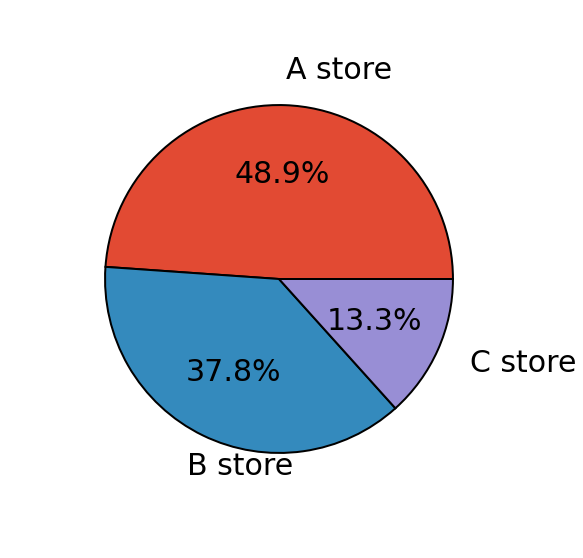

In [28]:
# Store Type Vs. Weekly Sales

sorted_type = stores_df.groupby('Type')
plt.style.use('ggplot')
labels=['A store','B store','C store']
sizes=sorted_type.describe()['Size'].round(1)
sizes=[(22/(17+6+22))*100,(17/(17+6+22))*100,(6/(17+6+22))*100] # convert to the proportion
fig, axes = plt.subplots(1,1, figsize=(10,10))
wprops={'edgecolor':'black',
      'linewidth':2}
tprops = {'fontsize':30}
axes.pie(sizes,
        labels=labels,
        explode=(0.0,0,0),
        autopct='%1.1f%%',
        pctdistance=0.6,
        labeldistance=1.2,
        wedgeprops=wprops,
        textprops=tprops,
        radius=0.8,
        center=(0.5,0.5))
plt.show()

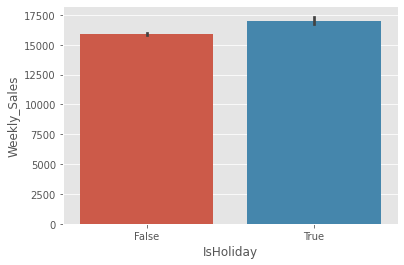

In [31]:
# Weekly Sales on holidays and non-holidays

holiday = final_walmart_df['Weekly_Sales'].loc[final_walmart_df['IsHoliday']== True]      # Weekly Sales in Holidays
non_holiday = final_walmart_df['Weekly_Sales'].loc[final_walmart_df['IsHoliday']== False] # Weekly Sales in Non-holidays.
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=final_walmart_df)


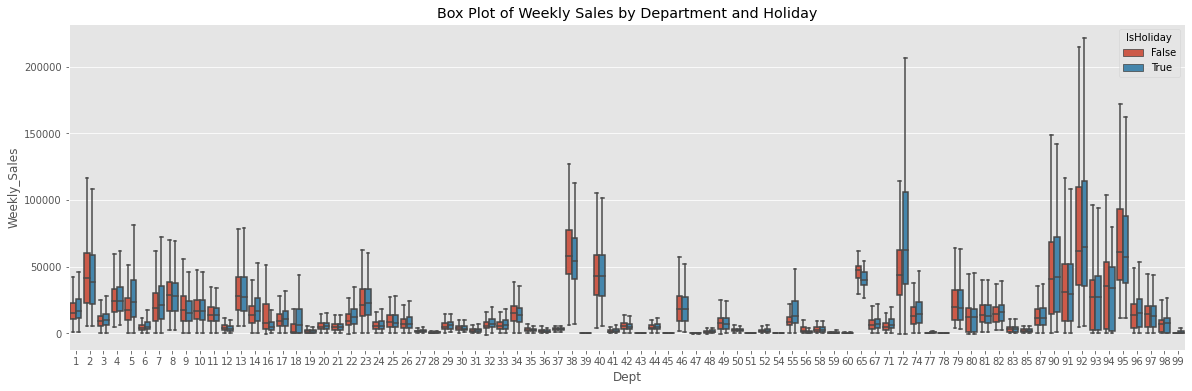

In [32]:
# Weekly Sales by Department and Holiday

data_11= pd.concat([final_walmart_df['Dept'], final_walmart_df['Weekly_Sales'], final_walmart_df['IsHoliday']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Department and Holiday')
fig = sns.boxplot(x='Dept', y='Weekly_Sales', data=data_11, showfliers=False, hue="IsHoliday")

In [40]:
final_walmart_df.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Type             object
Size              int64
dtype: object

In [47]:
final_walmart_df['Date'] = pd.to_datetime(final_walmart_df['Date'])
final_walmart_df['month'] = pd.DatetimeIndex(final_walmart_df['Date']).month
final_walmart_df.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,month
0,1,1,2010-05-02,24924.50,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,151315,5
1,1,1,2010-12-02,46039.49,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,151315,12


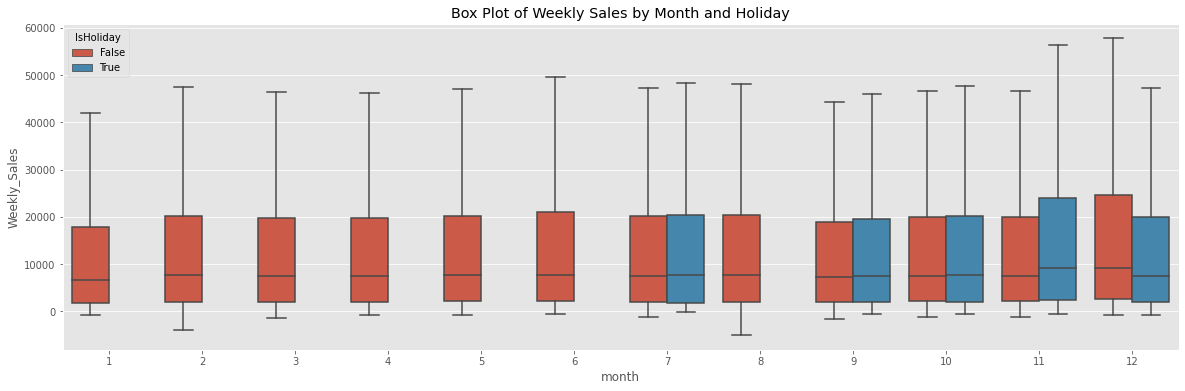

In [49]:
# Month wise Weekly Sales visualization
df_m = pd.concat([final_walmart_df['month'], final_walmart_df['Weekly_Sales'], final_walmart_df['IsHoliday']], axis=1)
plt.figure(figsize = (20,6))

plt.title('Box Plot of Weekly Sales by Month and Holiday')
fig = sns.boxplot(x = 'month', y = 'Weekly_Sales', data = df_m, showfliers = False, hue = 'IsHoliday')

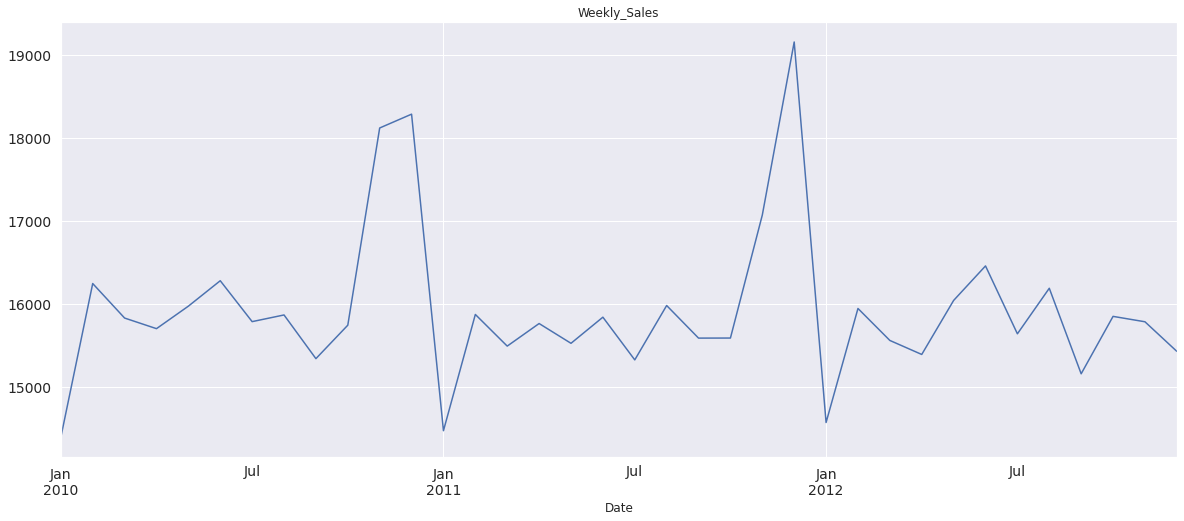

In [53]:
# Below plot is general idea of how the Weekly Sales has been so far

final_walmart_df.index = final_walmart_df.Date
final_walmart_df = final_walmart_df.drop('Date', axis=1)
final_walmart_df = final_walmart_df.resample('MS').mean()

train_dt = final_walmart_df['Weekly_Sales']
# Plot of Weekly_Sales with respect to years in train

train_dt.plot(figsize = (20,8), title = 'Weekly_Sales', fontsize = 14)
plt.show()

In [54]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf

--2021-03-07 11:34:53--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2021-03-07 11:34:53 (29.9 MB/s) - ‘colab_pdf.py’ saved [1864/1864]



In [55]:
colab_pdf('/content/drive/MyDrive/Colab Notebooks/BDA_Technical_Project_Data_Visualization_Kowsik_B.ipynb')

Mounted at /content/drive/


ValueError: ignored